In [ ]:
from IPython.display import display_html
def restartkernel(): display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
try: restartkernel()
except: pass

In [3]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [33]:
from condensate.core import gpcore
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
%matplotlib inline

from tqdm.notebook import tqdm
import time
import h5py
import pandas as pd
from scipy.ndimage import rotate as rotate_image
from scipy.optimize import curve_fit
import matplotlib.animation as animation
from IPython.display import HTML

In [34]:
# constants
hbar = 1.05e-34
a0 = 5.3e-11

In [ ]:
class Environment():
    def __init__(self, DIM=512, fov=)

In [35]:
class Wavefunction():
    def __init__(self, DIM=512, fov=400e-6, N=1e6, omegaz=10, a_s=100*a0, mass=3.8e-26):
        self.DIM = DIM
        self.fov = fov
        self.N = N
        self._omegaz = omegaz
        self.a_s = a_s
        self.mass = mass
        self.g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
        self.g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))
        self.omega = 2*np.pi
        self.epsilon = 0
        self.lb = np.sqrt(hbar / (2*mass *self.omega))
        
        self.Psi = (1+0.j)*np.zeros((DIM,DIM))
        self.V = np.zeros((DIM,DIM))
        self.initialize_Psi()
        self.reference_frame = {'rotating': False, 'omegaR': [self.omega]}
        self.absorber = {'on': False, 'strength': 1, 'radius': self.fov/2}
        self.edge = {'on': False, 'strength': 5, 'radius': self.fov/2, 'width':self.fov/20}
        self.spoon = {
            'type': None, 'strength':1e5, 'radius': 20e-6,
            'leapx': -250, 'leapy': -500, 'leapxscale': 1, 'leapyscale': 1, 'zcontrol': False
        }
        
        print(f'''
            Running condensate on {DIM}x{DIM} grid with:
            atom number: {N:.0e} 
            mass:        {mass:.2e}
        ''')
        
        
    @property
    def density(self):
        self._density = np.abs(self.Psi) ** 2
        return self._density
    
    @property
    def phase(self):
        self._phase = np.angle(self.Psi)
        return self._phase
    
        
    def show_density(self,):
        a = plt.imshow(self.density)
        plt.colorbar()
        plt.show()
        
    def show_phase(self,):
        a = plt.imshow(self.phase)
        plt.colorbar()
        plt.show()
        
    def show_potential(self, frame='auto'):
        if (frame=='auto' and self.reference_frame['rotating']) or (frame=='rotating'):
            omega = self.reference_frame['omegaR'][-1]
            for i in range(DIM):
                for j in range(DIM):
                    x = (i-DIM//2)*fov / DIM
                    y = (j-DIM//2)*fov / DIM
                    rsq = x**2 + y**2
                    centrif = 0.5 * mass * (omega**2) * rsq
                    self.V[i,j] -= centrif/hbar
        a = plt.contour(self.V)
        plt.gca().set_aspect('equal', 'box')
        plt.show()
        
    def initialize_Psi(self, width=100, vortexnumber=0):
        DIM = self.DIM
        x = (1+0.j)*np.zeros((DIM,DIM))
        for i in range(DIM):
            for j in range(DIM):
                phase = 1
                if vortexnumber:
                    phi = vortexnumber * np.arctan2((i-DIM//2), (j-DIM//2))
                    phase = np.exp(1.j * np.mod(phi,2*np.pi))
                self.Psi[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
                self.Psi[i,j] *= phase
        
    def harmonic_potential(self, omega, epsilon):
        self.omega = omega
        self.lb = np.sqrt(hbar / (2* self.mass *omega))
        self.epsilon = epsilon
        self.omegaz(np.sqrt(8) * omega)
            
    def omegaz(self, omegaz):
        self._omegaz = omegaz
        self.g = self.N* 4 * np.pi * (hbar**2) * (self.a_s  / self.mass)
        self.g *= np.sqrt(self.mass * omegaz / (2*np.pi*hbar))
        return self._omegaz
    
    def rotating_frame(self, omegaR):
        self.reference_frame = {'rotating': True, 'omegaR': omegaR}
    
    def lab_frame(self):
        self.reference_frame['rotating'] = False
            
    def absorbing_boundaries(self, strength, radius):
        self.absorber = {'on': True, 'strength': strength, 'radius': radius}
    
    def no_absorbing_boundaries(self):
        self.absorber['on'] = False
        
    def edge(self, strength, radius, width):
        self.edge = {'on': False, 'strength': strength, 'radius': radius, 'width': width}
    
    def no_edge(self):
        self.edge['on'] = False
    
    def relax(self, **kwargs):
        kwargs['imaginary_time'] = True
        self.evolve(**kwargs)

    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.__dict__.update(self.__dict__)
        return result

    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result
        
    
    
    def evolve(self, dt=1e-4, steps=1000, imaginary_time=False, cooling=0.01,
               showevery=40, show=True, vmax='auto'):
        
        gpcore.Setup(self.DIM, self.fov, self.g, dt, imaginary_time, cooling)
        
        gpcore.SetHarmonicPotential(self.omega, self.epsilon)
        
        if self.edge['on']:
            gpcore.SetEdgePotential(self.edge['strength'], self.edge['radius'], self.edge['width'])
            
        gpcore.GetPotential(self.V)
        
        if self.absorber['on']:
            gpcore.AbsorbingBoundaryConditions(self.absorber['strength'], self.absorber['radius'])
        
        if self.reference_frame['rotating']:
            omegaR = self.reference_frame['omegaR']
            if (steps!=0) and (len(omegaR)!=steps): 
                raise ValueError('Check the length of omegaR (it should be steps)')
            gpcore.RotatingFrame(omegaR)
        
        if self.spoon['type']=='mouse':
            gpcore.SetupSpoon(self.spoon['strength'], self.spoon['radius'])
        elif self.spoon['type']=='leap':
            gpcore.SetupSpoon(self.spoon['strength'], self.spoon['radius'])
            gpcore.SetupLeapMotion(self.spoon['leapx'], 
                                   self.spoon['leapy'],
                                   self.spoon['leapxscale'], 
                                   self.spoon['leapyscale'],
                                   self.spoon['zcontrol'])
            
        if vmax=='auto': vmax=np.max(self.density)
            
        gpcore.Evolve(self.Psi, int(steps), int(showevery), show, vmax)


# Geometric squeezing

In [36]:
omega = 2*np.pi*10
dt = 1e-5

c = Wavefunction(DIM=512, fov=300e-6, N=1e6)


            Running condensate on 512x512 grid with:
            atom number: 1e+06 
            mass:        3.80e-26
        


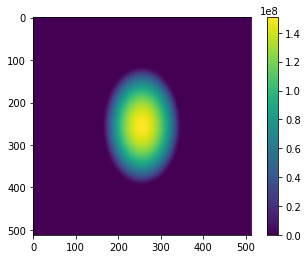

In [38]:
c.harmonic_potential(omega=omega, epsilon=0.4)
c.relax(vmax=3e8, dt=dt, steps=10000)
crelaxed = deepcopy(c)
c.show_density()

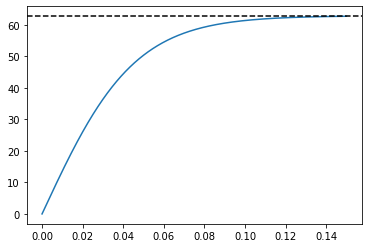

In [28]:
whirrMax = omega
steps = 30000
whirrtime = 30000
times = np.arange(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]

plt.plot(5e-6*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.show()

In [30]:
crelaxed.rotating_frame(omegaR=Omega)
crelaxed.absorbing_boundaries(strength=1, radius=c.fov/2)
crelaxed.evolve(dt=dt, steps=steps, cooling=0)

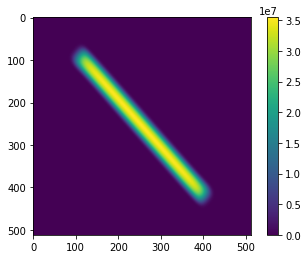

In [31]:

c.show_density()

In [17]:
c.lab_frame()

In [63]:
c.harmonic_potential(c.omega,0.2)

In [56]:
np.pi**(-0.25)

0.7511255444649425